In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, auc, roc_curve, roc_auc_score, confusion_matrix

from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.linear_model import LassoCV

# Loading Data

In [19]:
data = pd.read_csv('./data_processed/data_first_record_with_commorbidities_.csv', index_col=0)
data.fillna(data.mean(), inplace=True)
los_mean = data.los.mean()

In [20]:
data = data[data.die_in_icu == 0]
data.drop(columns=['die_in_icu'], inplace=True)

print(data.shape)

(988, 32)


In [21]:
# data.los = (data.los >= np.mean(data.los)).astype(int)
data.los = (data.los >= los_mean).astype(int)

In [22]:
X = data.loc[:, data.columns != 'los']
y = data.loc[:, data.columns == 'los']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost

## Binary Outcome

In [24]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic')

### Find Parameters

#### GridSearch

In [25]:
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0]
}

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           scoring='accuracy', 
                           cv=3, 
                           verbose=1,)

grid_search.fit(X_train, y_train)

print(f"Best parameters found: {grid_search.best_params_}")

y_pred = grid_search.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy with best parameters: {accuracy * 100.0}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
Accuracy with best parameters: 74.74747474747475


### Final Model

In [26]:
final_model = xgb.XGBClassifier(**grid_search.best_params_)

final_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [27]:
y_pred = final_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy with best parameters: {accuracy * 100.0}")

Accuracy with best parameters: 76.26262626262627


In [28]:
cm = confusion_matrix(y_test, y_pred)

cm

array([[148,   0],
       [ 47,   3]], dtype=int64)

### ROC Curve

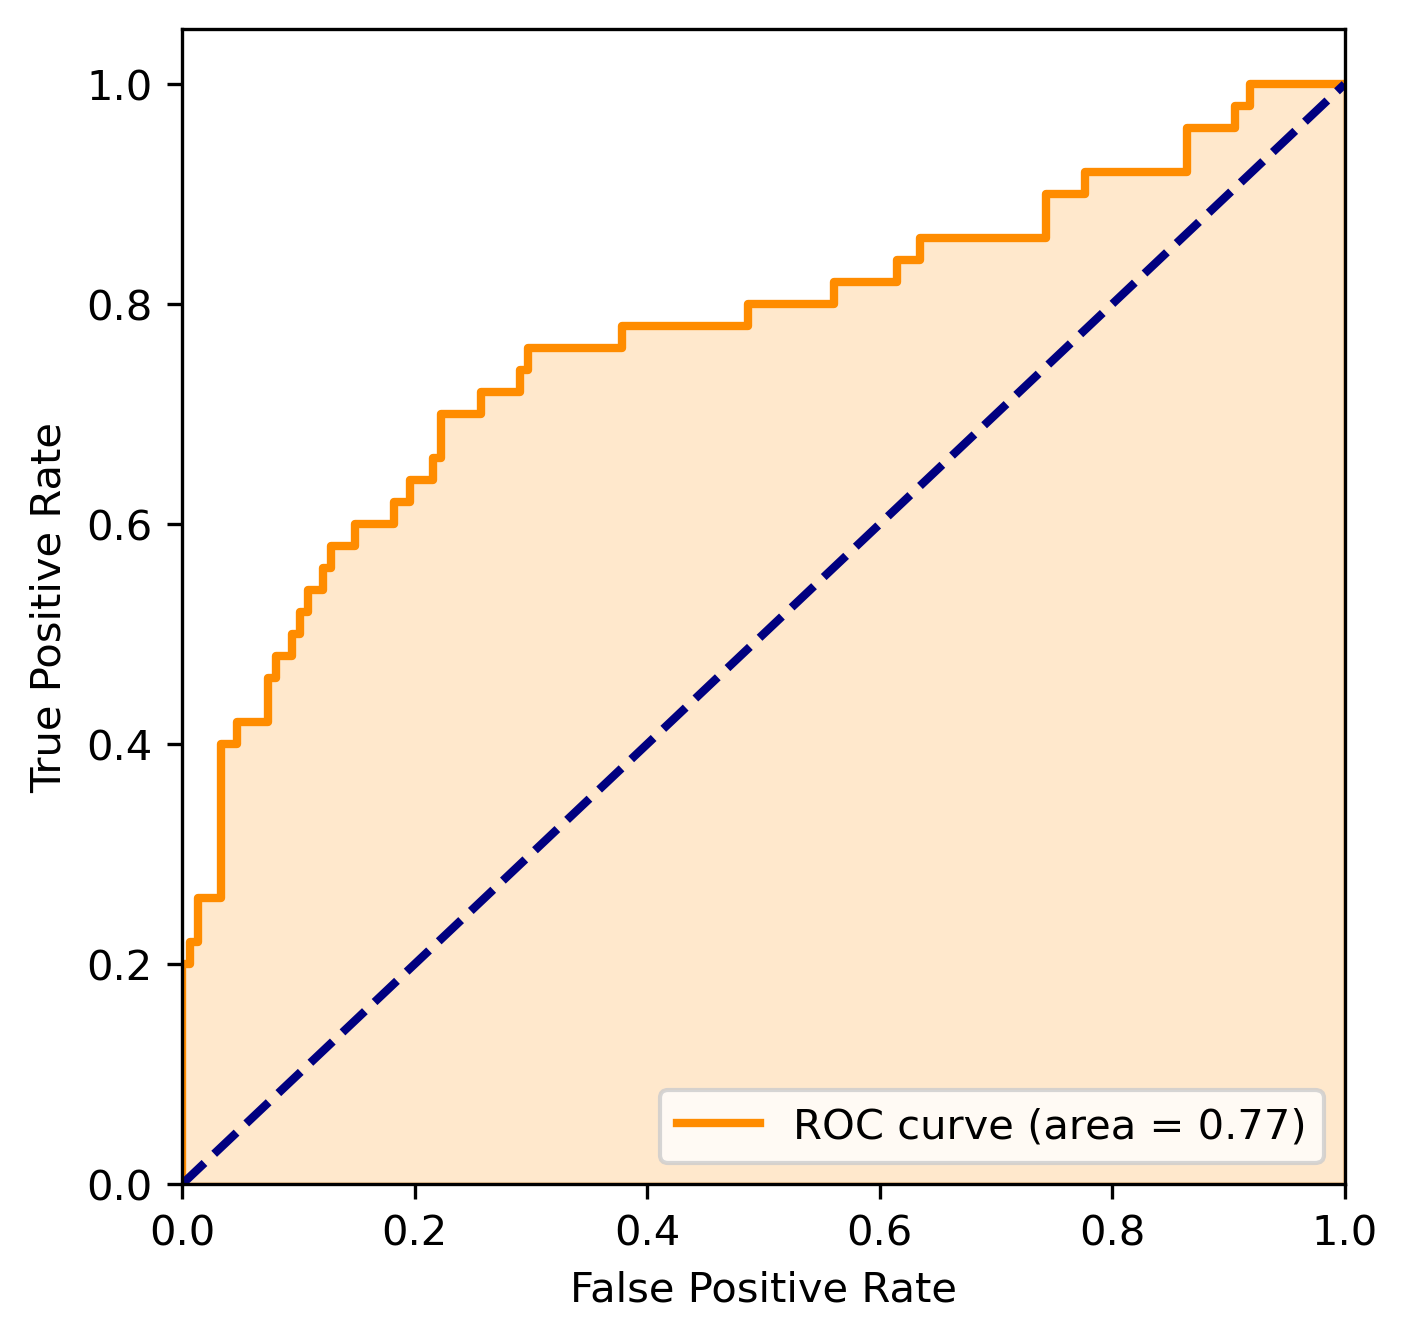

In [29]:
y_scores = final_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5), dpi=300)

plt.plot(fpr, 
         tpr, 
         color='darkorange', 
         lw=2, 
         label=f'ROC curve (area = {roc_auc:.2f})')

plt.fill_between(fpr, tpr, color='darkorange', alpha=0.2)  # alpha 参数控制填充颜色的透明度


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### Imporpant Matrix

In [30]:
importances = final_model.feature_importances_

feature_names = X.columns

importance_df = (
    pd.DataFrame(importances, index=feature_names, columns=['Importance'])
   .sort_values(by='Importance', ascending=False)
   .reset_index()
)

print(importance_df)


                                     index  Importance
0                Acute respiratory failure    0.078765
1                         respiratory_rate    0.044592
2                              Tachycardia    0.041555
3                                  uc_only    0.041407
4                                      rdw    0.040390
5        Hyposmolality and/or hyponatremia    0.038180
6                                   Anemia    0.037524
7                 Congestive heart failure    0.037322
8        Other finger(s) amputation status    0.036905
9                          insurance_Other    0.035778
10                                platelet    0.034697
11                              hematocrit    0.034130
12                              hemoglobin    0.033890
13                                     age    0.033754
14                                     mch    0.032873
15                       Diabetes mellitus    0.032616
16                 Urinary tract infection    0.032266
17        

In [31]:
importance_df.loc[:, 'index'].values

array(['Acute respiratory failure', 'respiratory_rate', 'Tachycardia',
       'uc_only', 'rdw', 'Hyposmolality and/or hyponatremia', 'Anemia',
       'Congestive heart failure', 'Other finger(s) amputation status',
       'insurance_Other', 'platelet', 'hematocrit', 'hemoglobin', 'age',
       'mch', 'Diabetes mellitus', 'Urinary tract infection', 'mcv',
       'Tobacco use disorder', 'Personal history of tobacco use',
       'Thrombocytopenia', 'Essential (primary) hypertension', 'gender',
       'heart_rate', 'insurance_Medicare', 'Severe sepsis',
       'Other specified intestinal obstruction', 'cd_only',
       'Acute kidney failure', 'marital_status_MARRIED',
       'language_ENGLISH'], dtype=object)

In [ ]:
# importance_df.to_csv('./importance_df.csv', index=False)